# Credit Card Fraud Detection 

## Introduction:
* With the provided information, build a model to predict whether this customer will commit fraud when using a credit card or not?
* It is important for credit card issuers to detect customers who commit credit card fraud so that when they buy products and services, they will not be charged for those products and services.
* This dataset contains transaction information with 492 TH frauds out of a total of 284,807 transactions. This is a severely imbalanced dataset with the positive class (fraud) accounting for 0.172% of all transactions. Therefore, we should not use metrics `Accuracy` to evaluate the model because the number of zero labels is too much, instead, we should focus on F1 Score, Precision/Recall, ROC_AUC or Confusion matrix to have more accurate assessment of the performance of the models

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing 
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import datasets, linear_model, metrics
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

##Load Data

In [4]:
df=pd.read_csv('dataset/creditcard.csv')
# Converting all column names to lower case
df.columns = df.columns.str.lower()
df.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


* Due to security issues, the original features V1, V2, ... V28 have been modified by PCA. However, we can guess that these features could be credit card number, expiration date, CVV, cardholder name, transaction location, transaction date-time, etc.
* The only two features that have not been converted with PCA are `Time` and `Amount`. Therefore, we only need to focus on processing these two features

##Exploratory Data Analysis

In [5]:
df.shape

(284807, 31)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   time    284807 non-null  float64
 1   v1      284807 non-null  float64
 2   v2      284807 non-null  float64
 3   v3      284807 non-null  float64
 4   v4      284807 non-null  float64
 5   v5      284807 non-null  float64
 6   v6      284807 non-null  float64
 7   v7      284807 non-null  float64
 8   v8      284807 non-null  float64
 9   v9      284807 non-null  float64
 10  v10     284807 non-null  float64
 11  v11     284807 non-null  float64
 12  v12     284807 non-null  float64
 13  v13     284807 non-null  float64
 14  v14     284807 non-null  float64
 15  v15     284807 non-null  float64
 16  v16     284807 non-null  float64
 17  v17     284807 non-null  float64
 18  v18     284807 non-null  float64
 19  v19     284807 non-null  float64
 20  v20     284807 non-null  float64
 21  v21     28

In [7]:
df.isnull().sum().sum()

0

This dataset has 29 `float` variables, 1 target variable is `int` and no missing values

In [8]:
df['class'].value_counts()/len(df)

0    0.998273
1    0.001727
Name: class, dtype: float64

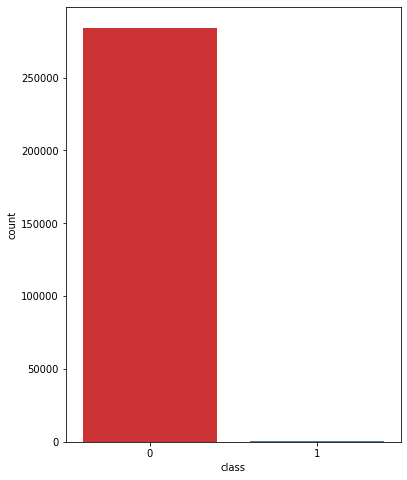

In [9]:
f,ax = plt.subplots(figsize=(6,8))
ax = sns.countplot(x='class', data=df, palette='Set1')
plt.show()

* This dataset contains transaction information with 492 TH frauds out of a total of 284,807 transactions. This is a severely imbalanced dataset with the positive class (fraud) accounting for 0.172% of all transactions

In [10]:
df[['time','amount']].describe()

,time,amount
count,284807.000000,284807.000000
mean,94813.859575,88.349619
std,47488.145955,250.120109
min,0.000000,0.000000
25%,54201.500000,5.600000
50%,84692.000000,22.000000
75%,139320.500000,77.165000
max,172792.000000,25691.160000


**Observations:**
* On average, each transaction happens every 94813s
* The TB transaction amount is 88.34 with a standard deviation of 250, the maximum transaction amount is 25691
* Based on mean and max, it is easy to see that these two variables have outliers

In [11]:
fraud = df[df['class']==1]
normal = df[df['class']==0]
print(f'Shape of Fraud Transactions: {fraud.shape}')
print(f'Shape of Normal Transactions: {normal.shape}')

Shape of Fraud Transactions: (492, 31)
Shape of Normal Transactions: (284315, 31)


In [12]:
pd.concat([fraud['amount'].describe(), normal['amount'].describe()], axis=1)

,amount,amount
count,492.000000,284315.000000
mean,122.211321,88.291022
std,256.683288,250.105092
min,0.000000,0.000000
25%,1.000000,5.650000
50%,9.250000,22.000000
75%,105.890000,77.050000
max,2125.870000,25691.160000


In [13]:
fraud['amount'].value_counts().head()

1.00     113
0.00      27
99.99     27
0.76      17
0.77      10
Name: amount, dtype: int64

**Observations:**
* With fraud transactions, the average amount of fraud is 122.22 USD, the highest is 2125 USD, the lowest is 0 and the maximum amount is 1 USD with 113 times.


###Distribution of Time

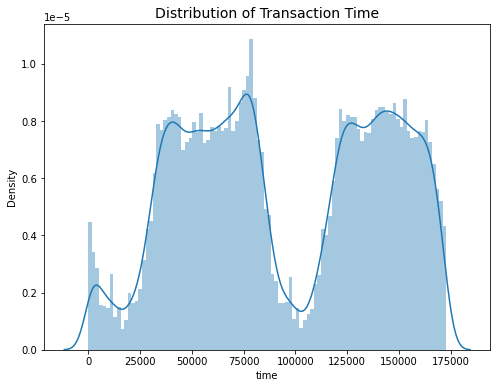

In [14]:
plt.figure(figsize=(8,6))
plt.title('Distribution of Transaction Time', fontsize=14)
sns.distplot(df['time'], bins=100)
plt.show()

**Observations:**
* This data set contains two-day trading information, looking at the distribution chart we see two peaks and two troughs. Most likely, the two peaks are transactions during the day because of the high volume of transactions, and the two bottoms are transactions at night when everyone is asleep.

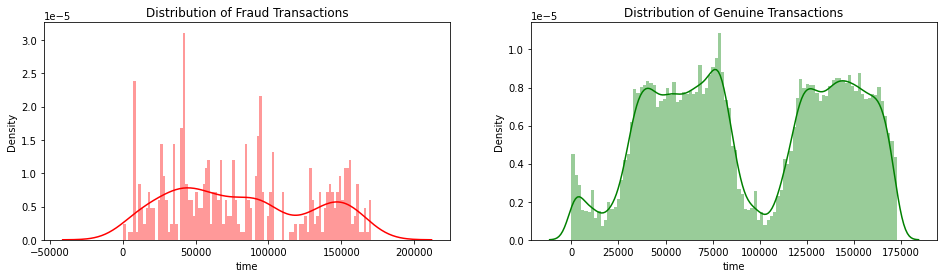

In [15]:
fig, axs = plt.subplots(ncols=2, figsize=(16,4))

sns.distplot(fraud['time'], bins=100, color='red', ax=axs[0])
axs[0].set_title("Distribution of Fraud Transactions")

sns.distplot(normal['time'], bins=100, color='green', ax=axs[1])
axs[1].set_title("Distribution of Genuine Transactions")

plt.show()

###Distribution of Amount

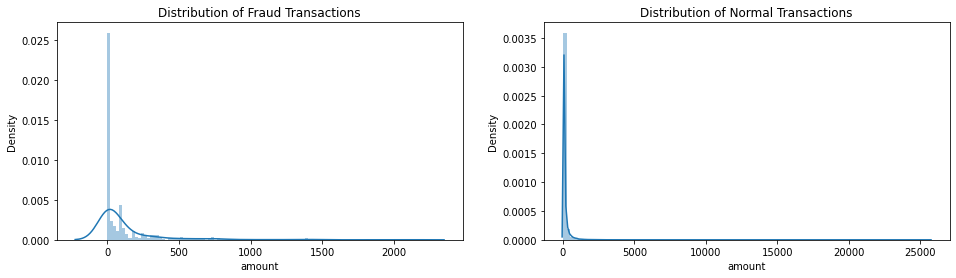

In [16]:
fig, axs = plt.subplots(ncols=2,figsize=(16,4))
sns.distplot(fraud['amount'], bins=100, ax=axs[0])
axs[0].set_title("Distribution of Fraud Transactions")

sns.distplot(normal['amount'], bins=100, ax=axs[1])
axs[1].set_title("Distribution of Normal Transactions")

plt.show()

In [17]:
# Scale amount by log
df['amount_log'] = np.log(df.amount + 0.0001)

Log transforms are useful when applied to skewed distributions because they tend to expand values in the lower magnitude range and tend to compress or reduce values in the magnitude range. higher

In [18]:
df.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v22,v23,v24,v25,v26,v27,v28,amount,class,amount_log
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,5.008099
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.989578
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,5.936639
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,4.816242
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,4.248354


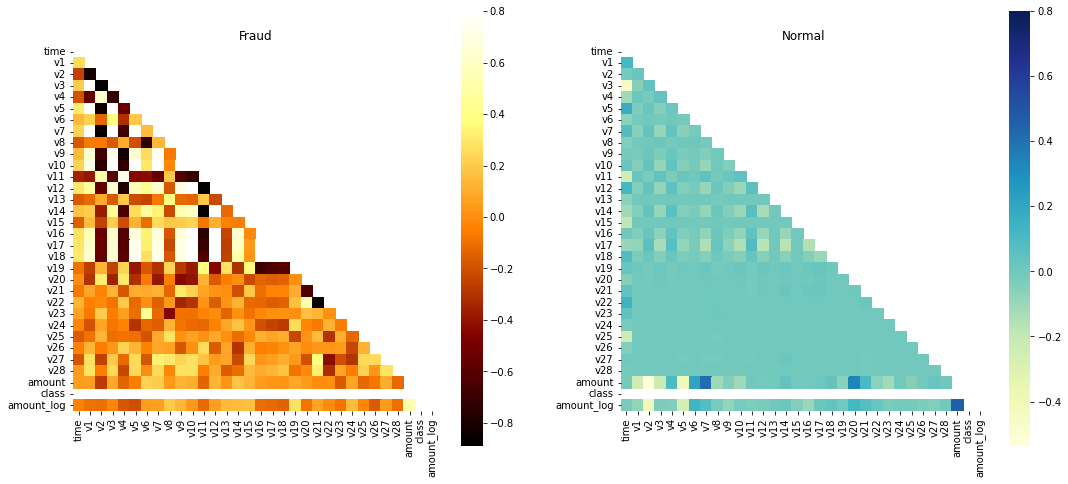

In [59]:
# Correlation matrix 
f, (ax1, ax2) = plt.subplots(1,2,figsize =( 18, 8))
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap((df.loc[df['class'] ==1]).corr(), vmax = .8, square=True, ax = ax1, cmap = 'afmhot', mask=mask);
ax1.set_title('Fraud')
sns.heatmap((df.loc[df['class'] ==0]).corr(), vmax = .8, square=True, ax = ax2, cmap = 'YlGnBu', mask=mask);
ax2.set_title('Normal')
plt.show()

##Spliting the data

In [19]:
X = df.drop(['class','time'], axis=1)

y = df['class']

In [20]:
# split X and y into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

X_train.shape, X_test.shape

((227845, 30), (56962, 30))

##Scaling the data

In [21]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

##SMOTE

In [22]:
from collections import Counter
from imblearn.over_sampling import SMOTE
print('Original dataset shape %s' % Counter(y_train))

smt = SMOTE(random_state=42)
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_train_smt))

Original dataset shape Counter({0: 227454, 1: 391})
Resampled dataset shape Counter({0: 227454, 1: 227454})


##Modeling

In [23]:
def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [57]:
import time
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, cohen_kappa_score, plot_confusion_matrix, roc_curve, classification_report
def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t0=time.time()
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    coh_kap = cohen_kappa_score(y_test, y_pred)
    time_taken = time.time()-t0
    print("Accuracy = {}".format(accuracy))
    print("ROC Area under Curve = {}".format(roc_auc))
    #print("Precision  = {}".format(precision))
    #print("Recall  = {}".format(recall))
    print("F1 Score  = {}".format(f1))
    print("Cohen's Kappa = {}".format(coh_kap))
    print("Time taken = {}".format(time_taken))
    print(classification_report(y_test,y_pred,digits=5))
    
    probs = model.predict_proba(X_test)  
    probs = probs[:, 1]  
    fper, tper, thresholds = roc_curve(y_test, probs) 
    plot_roc_cur(fper, tper)
    
    plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.Blues)
    
    return model, accuracy, roc_auc, f1, coh_kap, time_taken

###Logistic Regression

Accuracy = 0.9757908781292791
ROC Area under Curve = 0.9582237281430259
F1 Score  = 0.12109623964308477
Cohen's Kappa = 0.11817037698754529
Time taken = 17.78870129585266
              precision    recall  f1-score   support

           0    0.99989   0.97585   0.98773     56861
           1    0.06471   0.94059   0.12110       101

    accuracy                        0.97579     56962
   macro avg    0.53230   0.95822   0.55441     56962
weighted avg    0.99823   0.97579   0.98619     56962



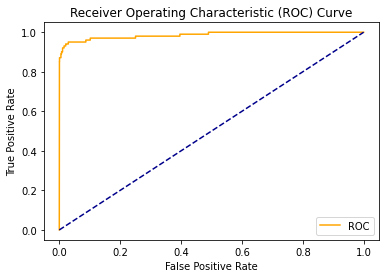

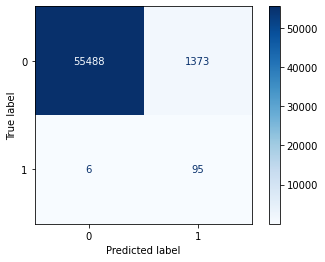

In [25]:
# Logistic Regression with SMOTE
from sklearn.linear_model import LogisticRegression

params_lr = {'penalty': 'l1', 'solver':'liblinear'}

model_lrsmt = LogisticRegression(**params_lr)
model_lrsmt, accuracy_lrsmt, roc_auc_lrsmt,f1_score_lrsmt,coh_kap_lrsmt, tt_lrsmt = run_model(model_lrsmt, X_train_smt, y_train_smt, X_test, y_test)

###Decision Tree

Accuracy = 0.9902566623362944
ROC Area under Curve = 0.9012273459631712
F1 Score  = 0.22809457579972184
Cohen's Kappa = 0.225734556245497
Time taken = 4.400159120559692
              precision    recall  f1-score   support

           0    0.99966   0.99057   0.99510     56861
           1    0.13269   0.81188   0.22809       101

    accuracy                        0.99026     56962
   macro avg    0.56617   0.90123   0.61160     56962
weighted avg    0.99813   0.99026   0.99374     56962



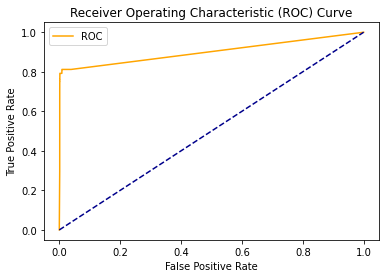

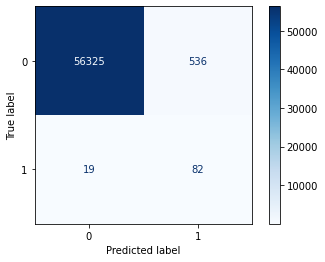

In [26]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

params_dt = {'max_depth': 16,
             'max_features': "sqrt"}

model_dtsmt = DecisionTreeClassifier(**params_dt)
model_dtsmt, accuracy_dtsmt, roc_auc_dtsmt, f1_score_dtsmt,coh_kap_dtsmt, tt_dtsmt = run_model(model_dtsmt, X_train_smt, y_train_smt, X_test, y_test)

###Random Forest

Accuracy = 0.9995084442259752
ROC Area under Curve = 0.9206865587281543
F1 Score  = 0.8585858585858587
Cohen's Kappa = 0.8583397534497652
Time taken = 318.77797985076904
              precision    recall  f1-score   support

           0    0.99972   0.99979   0.99975     56861
           1    0.87629   0.84158   0.85859       101

    accuracy                        0.99951     56962
   macro avg    0.93800   0.92069   0.92917     56962
weighted avg    0.99950   0.99951   0.99950     56962



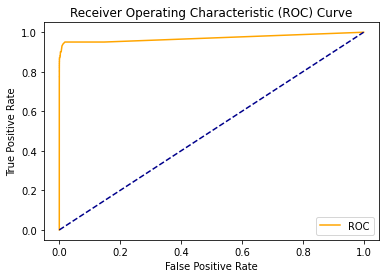

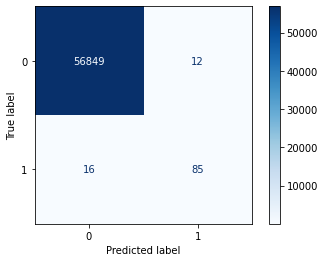

In [27]:
# Random Forest with SMOTE
from sklearn.ensemble import RandomForestClassifier

model_rfsmt = RandomForestClassifier()
model_rfsmt, accuracy_rfsmt, roc_auc_rfsmt, f1_score_rfsmt,coh_kap_rfsmt, tt_rfsmt = run_model(model_rfsmt, X_train_smt, y_train_smt, X_test, y_test)

###LightGBM

Accuracy = 0.9985077771145676
ROC Area under Curve = 0.8954768280683083
F1 Score  = 0.6530612244897959
Cohen's Kappa = 0.6523365857658603
Time taken = 4.842337131500244
              precision    recall  f1-score   support

           0    0.99963   0.99887   0.99925     56861
           1    0.55556   0.79208   0.65306       101

    accuracy                        0.99851     56962
   macro avg    0.77759   0.89548   0.82616     56962
weighted avg    0.99884   0.99851   0.99864     56962



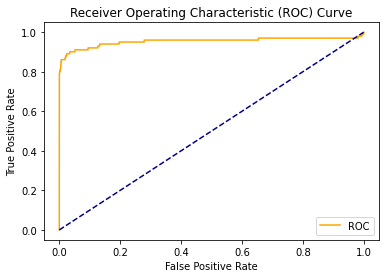

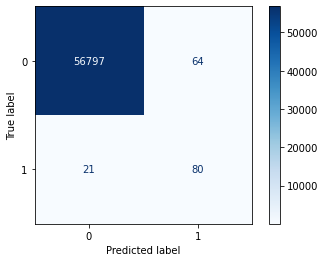

In [28]:
# Light GBM with SMOTE
import lightgbm as lgb

model_lgbsmt = lgb.LGBMClassifier()
model_lgbsmt, accuracy_lgbsmt, roc_auc_lgbsmt, f1_score_lgbsmt,coh_kap_lgbsmt, tt_lgbsmt = run_model(model_lgbsmt, X_train_smt, y_train_smt, X_test, y_test)

###Catboost

In [29]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.1 MB/s 


Learning rate set to 0.5
0:	learn: 0.0939020	total: 6.69s	remaining: 2m 7s
1:	learn: 0.0369052	total: 14.1s	remaining: 2m 6s
2:	learn: 0.0199681	total: 21.6s	remaining: 2m 2s
3:	learn: 0.0125476	total: 28.4s	remaining: 1m 53s
4:	learn: 0.0086885	total: 34s	remaining: 1m 42s
5:	learn: 0.0059908	total: 39.6s	remaining: 1m 32s
6:	learn: 0.0042267	total: 45.3s	remaining: 1m 24s
7:	learn: 0.0034408	total: 50.8s	remaining: 1m 16s
8:	learn: 0.0028330	total: 56.5s	remaining: 1m 9s
9:	learn: 0.0023885	total: 1m 2s	remaining: 1m 2s
10:	learn: 0.0021404	total: 1m 7s	remaining: 55.3s
11:	learn: 0.0018040	total: 1m 13s	remaining: 48.8s
12:	learn: 0.0015751	total: 1m 18s	remaining: 42.4s
13:	learn: 0.0012856	total: 1m 24s	remaining: 36.2s
14:	learn: 0.0011690	total: 1m 29s	remaining: 30s
15:	learn: 0.0010272	total: 1m 35s	remaining: 23.9s
16:	learn: 0.0009326	total: 1m 41s	remaining: 17.8s
17:	learn: 0.0008497	total: 1m 46s	remaining: 11.9s
18:	learn: 0.0007541	total: 1m 52s	remaining: 5.92s
19:	lea

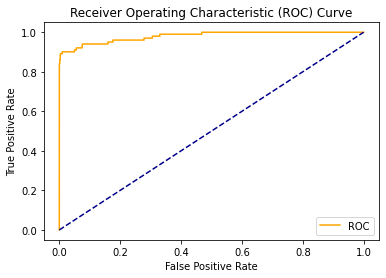

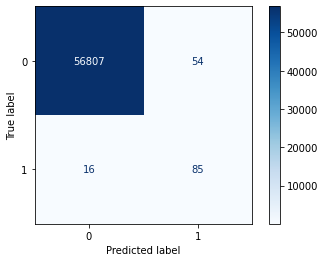

In [30]:
# Catboost
import catboost as cb
params_cb ={'iterations': 20,
            'max_depth': 16}

model_cbsmt = cb.CatBoostClassifier(**params_cb)
model_cbsmt, accuracy_cbsmt, roc_auc_cbsmt, f1_score_cbsmt,coh_kap_cbsmt, tt_cbsmt = run_model(model_cbsmt, X_train_smt, y_train_smt, X_test, y_test)

###XGBoost

Accuracy = 0.9984199992977775
ROC Area under Curve = 0.9102579662303122
F1 Score  = 0.6484375
Cohen's Kappa = 0.6476810261754515
Time taken = 127.98923969268799
              precision    recall  f1-score   support

           0    0.99968   0.99873   0.99921     56861
           1    0.53548   0.82178   0.64844       101

    accuracy                        0.99842     56962
   macro avg    0.76758   0.91026   0.82382     56962
weighted avg    0.99886   0.99842   0.99859     56962



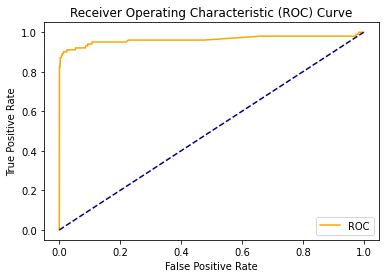

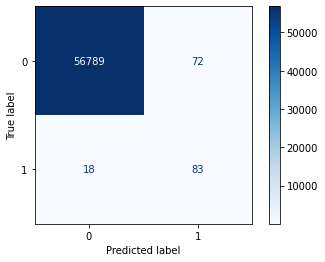

In [31]:
# XGBoost with SMOTE
import xgboost as xgb
params_xgb ={'n_estimators': 20,
            'max_depth': 16}

model_xgbsmt = xgb.XGBClassifier(**params_xgb)
model_xgbsmt, accuracy_xgbsmt, roc_auc_xgbsmt, f1_score_xgbsmt,coh_kap_xgbsmt, tt_xgbsmt = run_model(model_xgbsmt, X_train_smt, y_train_smt, X_test, y_test)

###AdaBoost

Accuracy = 0.9898528843790597
ROC Area under Curve = 0.9207919050817165
F1 Score  = 0.22933333333333333
Cohen's Kappa = 0.22696113551593144
Time taken = 247.0561490058899
              precision    recall  f1-score   support

           0    0.99973   0.99010   0.99489     56861
           1    0.13251   0.85149   0.22933       101

    accuracy                        0.98985     56962
   macro avg    0.56612   0.92079   0.61211     56962
weighted avg    0.99820   0.98985   0.99354     56962



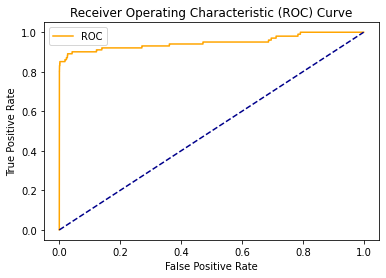

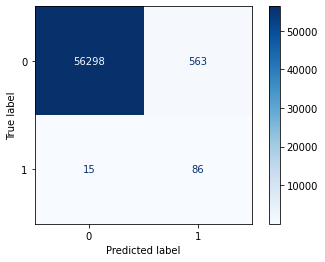

In [32]:
from sklearn.ensemble import AdaBoostClassifier
model_adasmt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),
                                  n_estimators=50,
                                  algorithm="SAMME.R",
                                  learning_rate=0.5)
model_adasmt, accuracy_adasmt, roc_auc_adasmt, f1_score_adasmt,coh_kap_adasmt, tt_adasmt = run_model(model_adasmt, X_train_smt, y_train_smt, X_test, y_test)

### TabNet

In [33]:
!pip install pytorch-tabnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F

import random

from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.metrics import Metric
from pathlib import Path

In [35]:
class F1Score(Metric):
    def __init__(self):
        self._name = "f1_score"
        self._maximize = True

    def __call__(self, y_true, y_pred):
        return f1_score(y_true, np.argmax(y_pred, axis = 1))

In [36]:
tabnet_params = dict(n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    cat_idxs=[],
    cat_dims = [],
    cat_emb_dim=1,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2, weight_decay = 1e-5),
    scheduler_params = dict(
        mode = "max", patience = 5, min_lr = 1e-5, factor = 0.9),                 
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau, 
    mask_type='entmax',
    verbose =10
)

In [42]:
import itertools

# Create a confusion matrix
def custom_plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [47]:
def run_tabnet_model(model, X_train, y_train, X_test, y_test):

    t0=time.time()

    model.fit(X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_name=['train', 'valid'],
        max_epochs = 200,
        patience = 50,
        batch_size = 1024 * 15, 
        virtual_batch_size = 256 * 10,
        num_workers = 4,
        drop_last = False,
        eval_metric=['f1_score']
        )
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    coh_kap = cohen_kappa_score(y_test, y_pred)
    time_taken = time.time()-t0
    print("Accuracy = {}".format(accuracy))
    print("ROC Area under Curve = {}".format(roc_auc))
    #print("Precision  = {}".format(precision))
    #print("Recall  = {}".format(recall))
    print("F1 Score  = {}".format(f1))
    print("Cohen's Kappa = {}".format(coh_kap))
    print("Time taken = {}".format(time_taken))
    print(classification_report(y_test,y_pred,digits=5))
    
    probs = model.predict_proba(X_test)  
    probs = probs[:, 1]  
    fper, tper, thresholds = roc_curve(y_test, probs) 
    plot_roc_cur(fper, tper)
    
    oversample_cm = confusion_matrix(y_test, y_pred)
    custom_plot_confusion_matrix(oversample_cm, classes = [0, 1], title="TabNet + SMOTE \n Confusion Matrix", cmap=plt.cm.Blues)
    
    return model, accuracy, roc_auc, f1, coh_kap, time_taken

Device used : cuda
epoch 0  | loss: 0.28386 | train_f1_score: 0.74698 | valid_f1_score: 0.00522 |  0:00:05s
epoch 10 | loss: 0.00709 | train_f1_score: 0.99853 | valid_f1_score: 0.47911 |  0:01:18s
epoch 20 | loss: 0.00412 | train_f1_score: 0.99936 | valid_f1_score: 0.60215 |  0:02:17s
epoch 30 | loss: 0.00666 | train_f1_score: 0.99814 | valid_f1_score: 0.4607  |  0:03:16s
epoch 40 | loss: 0.00229 | train_f1_score: 0.99952 | valid_f1_score: 0.65587 |  0:04:15s
epoch 50 | loss: 0.00139 | train_f1_score: 0.99979 | valid_f1_score: 0.67556 |  0:05:15s
epoch 60 | loss: 0.00288 | train_f1_score: 0.99965 | valid_f1_score: 0.68313 |  0:06:15s
epoch 70 | loss: 0.00097 | train_f1_score: 0.9997  | valid_f1_score: 0.72115 |  0:07:15s
epoch 80 | loss: 0.00107 | train_f1_score: 0.99987 | valid_f1_score: 0.72321 |  0:08:15s
epoch 90 | loss: 0.00221 | train_f1_score: 0.99945 | valid_f1_score: 0.6171  |  0:09:15s
epoch 100| loss: 0.00148 | train_f1_score: 0.99975 | valid_f1_score: 0.72961 |  0:10:10s
ep

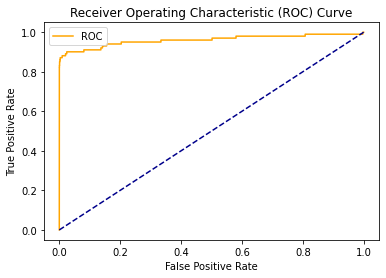

Confusion matrix, without normalization
[[56845    16]
 [   18    83]]


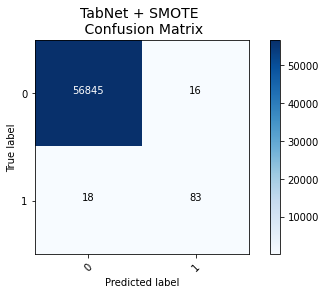

In [48]:
model_tabnetsmt =  TabNetClassifier(**tabnet_params)

model_tabnetsmt, accuracy_tabnetsmt, roc_auc_tabnetsmt, f1_score_tabnetsmt,coh_kap_tabnetsmt, tt_tabnetsmt = run_tabnet_model(model_tabnetsmt, X_train_smt, y_train_smt, X_test, y_test)

##Model Selection

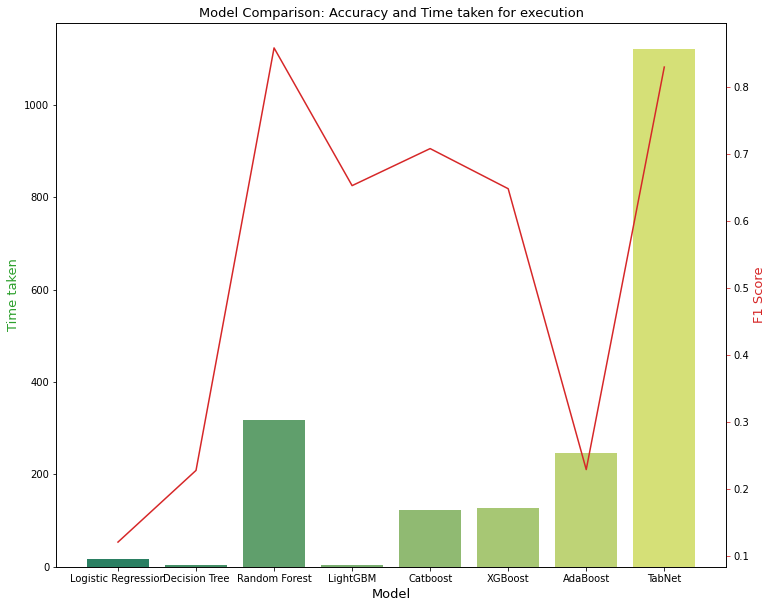

In [50]:
accuracy_scores = [accuracy_lrsmt, accuracy_dtsmt, accuracy_rfsmt, accuracy_lgbsmt, accuracy_cbsmt, accuracy_xgbsmt, accuracy_adasmt, accuracy_tabnetsmt]
roc_auc_scores = [roc_auc_lrsmt, roc_auc_dtsmt, roc_auc_rfsmt, roc_auc_lgbsmt, roc_auc_cbsmt, roc_auc_xgbsmt, roc_auc_adasmt, roc_auc_tabnetsmt]
f1_scores = [f1_score_lrsmt, f1_score_dtsmt, f1_score_rfsmt, f1_score_lgbsmt, f1_score_cbsmt, f1_score_xgbsmt, f1_score_adasmt, f1_score_tabnetsmt]
coh_kap_scores = [coh_kap_lrsmt, coh_kap_dtsmt,coh_kap_rfsmt, coh_kap_lgbsmt, coh_kap_cbsmt, coh_kap_xgbsmt, coh_kap_adasmt, coh_kap_tabnetsmt]
tt = [tt_lrsmt, tt_dtsmt, tt_rfsmt, tt_lgbsmt, tt_cbsmt, tt_xgbsmt, tt_adasmt, tt_tabnetsmt]

model_data = {'Model': ['Logistic Regression','Decision Tree','Random Forest','LightGBM','Catboost','XGBoost', 'AdaBoost', 'TabNet'],
              'Accuracy': accuracy_scores,
              'ROC_AUC': roc_auc_scores,
              'F1 Score': f1_scores,
              'Cohen_Kappa': coh_kap_scores,
              'Time taken': tt}
data = pd.DataFrame(model_data)

fig, ax1 = plt.subplots(figsize=(12,10))
ax1.set_title('Model Comparison: Accuracy and Time taken for execution', fontsize=13)
color = 'tab:green'
ax1.set_xlabel('Model', fontsize=13)
ax1.set_ylabel('Time taken', fontsize=13, color=color)
ax2 = sns.barplot(x='Model', y='Time taken', data = data, palette='summer')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('F1 Score', fontsize=13, color=color)
ax2 = sns.lineplot(x='Model', y='F1 Score', data = data, sort=False, color=color)
ax2.tick_params(axis='y', color=color)

The Random Forest model gives the best `f1_score` results but the training time is long and computationally expensive and TabNet model is overfitting, so for optimization we will choose the `LightGBM` model for fine-tuning.

##Fine Tuning

In [51]:
!pip install --quiet optuna

     |████████████████████████████████| 308 kB 7.4 MB/s 
     |████████████████████████████████| 209 kB 82.1 MB/s 
     |████████████████████████████████| 81 kB 11.1 MB/s 
     |████████████████████████████████| 78 kB 8.3 MB/s 
     |████████████████████████████████| 147 kB 90.8 MB/s 
     |████████████████████████████████| 112 kB 74.7 MB/s 
     |████████████████████████████████| 49 kB 7.2 MB/s 


In [52]:
import optuna  # pip install optuna
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

def objective(trial, X_train_smt, y_train_smt):
    max_depth=trial.suggest_int('max_depth',2,14)
    param_grid = {
        #         "device_type": trial.suggest_categorical("device_type", ['gpu']),
        #"n_estimators": trial.suggest_categorical("n_estimators", 1,300 ),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 4, 2**max_depth),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 500),
        "max_bin": trial.suggest_int("max_bin", 10, 300),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95, step=0.1)
    }
    #scoring = {'accuracy' : make_scorer(accuracy_score), 
    #      'precision' : make_scorer(precision_score),
    #     'recall' : make_scorer(recall_score), 
    #    'f1_score' : make_scorer(f1_score)}

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    model = lgb.LGBMClassifier(**param_grid)
    model.fit(X_train_smt,y_train_smt)
    scores = cross_val_score(model, X_train_smt, y_train_smt,
                             scoring=make_scorer(f1_score, average='weighted', labels=[1]),cv=cv, n_jobs=-1)
    return np.mean(scores)

In [53]:
study = optuna.create_study(direction='maximize')
func = lambda trial: objective(trial, X_train_smt, y_train_smt)
study.optimize(func, n_trials=100)

[I 2022-07-31 00:38:04,267] A new study created in memory with name: no-name-ac0a55cb-d40a-40db-a49a-098168374496
[I 2022-07-31 00:38:33,969] Trial 0 finished with value: 0.9974027037921788 and parameters: {'max_depth': 6, 'learning_rate': 0.0808499324423164, 'num_leaves': 38, 'min_data_in_leaf': 261, 'max_bin': 78, 'lambda_l1': 45, 'lambda_l2': 45, 'min_gain_to_split': 7.23178728515051, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 0 with value: 0.9974027037921788.
[I 2022-07-31 00:38:52,259] Trial 1 finished with value: 0.9818466886898914 and parameters: {'max_depth': 14, 'learning_rate': 0.19683326680434887, 'num_leaves': 8507, 'min_data_in_leaf': 337, 'max_bin': 110, 'lambda_l1': 85, 'lambda_l2': 65, 'min_gain_to_split': 6.645617046438769, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 0 with value: 0.9974027037921788.
[I 2022-07-31 00:39:10,555] Trial 2 finished with value: 0.

In [ ]:
print(f"\tBest value (Accuracy): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

Accuracy = 0.9992977774656788
ROC Area under Curve = 0.93046444160077
F1 Score  = 0.8130841121495327
Cohen's Kappa = 0.8127334482777326
Time taken = 6.331333160400391
              precision    recall  f1-score   support

           0    0.99975   0.99954   0.99965     56861
           1    0.76991   0.86139   0.81308       101

    accuracy                        0.99930     56962
   macro avg    0.88483   0.93046   0.90637     56962
weighted avg    0.99935   0.99930   0.99932     56962



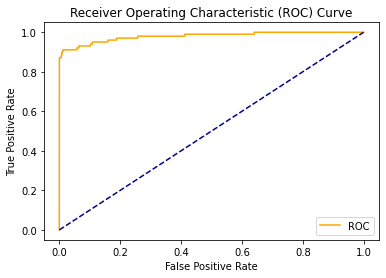

(LGBMClassifier(bagging_fraction=0.9, bagging_freq=1, feature_fraction=0.2,
                lambda_l1=0, lambda_l2=0, learning_rate=0.22690320686746146,
                max_bin=61, max_depth=13, min_data_in_leaf=168,
                min_gain_to_split=1.2780588498979437, num_leaves=501),
 0.9992977774656788,
 0.93046444160077,
 0.8130841121495327,
 0.8127334482777326,
 6.331333160400391)

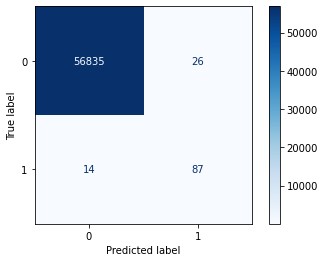

In [100]:
param_lgb = {'max_depth': 13,
		'learning_rate': 0.22690320686746146,
		'num_leaves': 501,
		'min_data_in_leaf': 168,
		'max_bin': 61,
		'lambda_l1': 0,
		'lambda_l2': 0,
		'min_gain_to_split': 1.2780588498979437,
		'bagging_fraction': 0.9,
		'bagging_freq': 1,
		'feature_fraction': 0.2    
}

lgb_opt = lgb.LGBMClassifier(**param_lgb)
run_model(lgb_opt, X_train_smt, y_train_smt, X_test, y_test)

In [110]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
import plotly.io as pio
pio.renderers.default='colab'

def model_performance(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)[:,1]

    #Conf matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)"],
                        y = ["0 (true)","1 (true)"],xgap = 2, ygap = 2,
                        text = conf_matrix,
                        colorscale = 'Viridis', showscale  = False)

    #Show metrics
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]
    Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    Precision =  (tp/(tp+fp))
    Recall    =  (tp/(tp+fn))
    F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))

    show_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score]])
    show_metrics = show_metrics.T

    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x = (show_metrics[0].values), 
                   y = ['Accuracy', 'Precision', 'Recall', 'F1_score'], text = np.round_(show_metrics[0].values,4),
                    textposition = 'auto',
                   orientation = 'h', opacity = 0.8,marker=dict(
            color=colors,
            line=dict(color='#000000',width=1.5)))
    
    #Roc curve
    model_roc_auc = round(roc_auc_score(y_test, y_score) , 3)
    fpr, tpr, t = roc_curve(y_test, y_score)
    trace3 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2), fill='tozeroy')
    trace4 = go.Scatter(x = [0,1],y = [0,1],
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))
    
    # Precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    trace5 = go.Scatter(x = recall, y = precision,
                        name = "Precision" + str(precision),
                        line = dict(color = ('lightcoral'),width = 2), fill='tozeroy')
    
    #Feature importance
    coefficients  = pd.DataFrame(model.feature_importances_)
    column_data   = pd.DataFrame(list(df))
    coef_sumry    = (pd.merge(coefficients,column_data,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False)
    coef_sumry = coef_sumry[coef_sumry["coefficients"] !=0]
    trace6 = go.Bar(x = coef_sumry["features"],y = coef_sumry["coefficients"],
                    name = "coefficients",
                    marker = dict(color = coef_sumry["coefficients"],
                                  colorscale = "Viridis",
                                  line = dict(width = .6,color = "black")))
    
    #Cumulative gain
    pos = pd.get_dummies(y_test).values
    pos = pos[:,1] 
    npos = np.sum(pos)
    index = np.argsort(y_score) 
    index = index[::-1] 
    sort_pos = pos[index]
    #cumulative sum
    cpos = np.cumsum(sort_pos) 
    #recall
    recall = cpos/npos 
    #size obs test
    n = y_test.shape[0] 
    size = np.arange(start=1,stop=369,step=1) 
    #proportion
    size = size / n 
    #plots
    model = model
    trace7 = go.Scatter(x = size,y = recall,
                        name = "Lift curve",
                        line = dict(color = ('gold'),width = 2), fill='tozeroy') 
    
    #Subplots
    fig = tls.make_subplots(rows=4, cols=2, print_grid=False, 
                          specs=[[{}, {}], 
                                 [{}, {}],
                                 [{'colspan': 2}, None],
                                 [{'colspan': 2}, None]],
                          subplot_titles=('Confusion Matrix',
                                        'Metrics',
                                        'ROC curve'+" "+ '('+ str(model_roc_auc)+')',
                                        'Precision - Recall curve',
                                        'Cumulative gains curve',
                                        'Feature importance',
                                        ))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,2,1)
    fig.append_trace(trace4,2,1)
    fig.append_trace(trace5,2,2)
    fig.append_trace(trace6,4,1)
    fig.append_trace(trace7,3,1)
    
    fig['layout'].update(showlegend = False, title = '<b>Model performance report</b><br>' + 'LightGBM after tuning',
                        autosize = False, height = 1500,width = 830,
                        plot_bgcolor = 'rgba(240,240,240, 0.95)',
                        paper_bgcolor = 'rgba(240,240,240, 0.95)',
                        margin = dict(b = 195))
    fig["layout"]["xaxis2"].update((dict(range=[0, 1])))
    fig["layout"]["xaxis3"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis3"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis4"].update(dict(title = "recall"), range = [0,1.05])
    fig["layout"]["yaxis4"].update(dict(title = "precision"), range = [0,1.05])
    fig["layout"]["xaxis5"].update(dict(title = "Percentage contacted"))
    fig["layout"]["yaxis5"].update(dict(title = "Percentage positive targeted"))
    fig.layout.titlefont.size = 14
    
    fig.show("colab")
    # pio.write_image(fig, "op.png")

In [111]:
model_performance(lgb_opt, X_test, y_test)

Output hidden; open in https://colab.research.google.com to view.

**Observation:**
* The model has improved significantly with the `f1_score` index increased from 65.3% to 81.3%
* With the Credit Card Fraud Detection problem, we should focus on reducing the number of Type I (FP) errors that the model predicts. Customers fall into the category I error about the fact that they committed fraud, but the model predicts that these customers do not commit fraud. This leads to a great loss for credit institutions when we have wrongly predicted these customers.
* Therefore, in addition to choosing a good model, we also need to choose the models with the lowest error types of type I.

=> The `LightGBM` model will be the chosen model to solve this problem!